## Interpolation of raw data

The raw data contains for each frame (~60 FPS): time, 4x4 transformation matrix, velocity (xyz).

Interpolate all values over the time axis since the frame rate sometimes spikes/drops.

In [ ]:
import pandas as pd
import numpy as np
import scipy.interpolate
import math

np.set_printoptions(suppress=True)

def interpolate(inp, out):
  df = pd.read_csv(inp)
  data = df.to_numpy()

  t = np.arange(data[0, 0], data[-1, 0], 0.05)
  result = []

  # Interpolate each axis independently according to the first column (time)
  for i in range(data.shape[1]):
    result.append(scipy.interpolate.interp1d(data[:, 0], data[:, i])(t))
  
  pd.DataFrame(np.asarray(result).T, columns=df.columns).to_csv(out, float_format="%.5f", index=False)

interpolate("raw_1.csv", "interp_1.csv")
interpolate("raw_2.csv", "interp_2.csv")
interpolate("raw_3.csv", "interp_3.csv")

## Visualization of test data

This shows the recorded, interpolated positions used during testing.

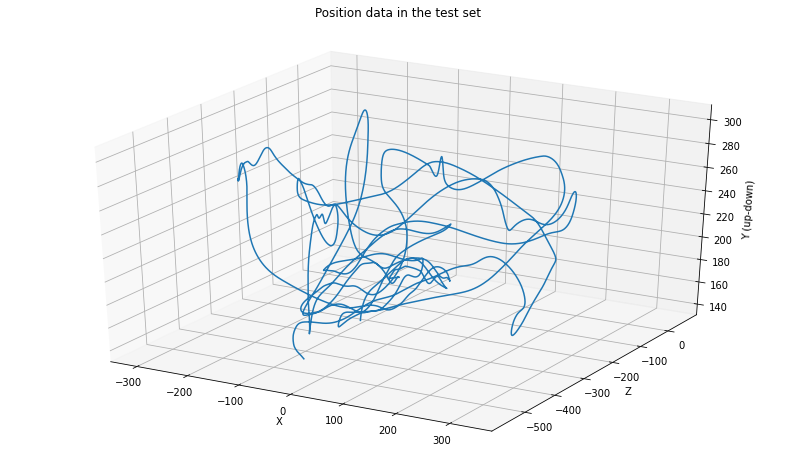

In [ ]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

df = pd.read_csv("interp_2.csv")
data = df.to_numpy()

# [0]: t
# [1]: m11  [2]:  m12 [3]:  m13 [4]:  m14
# [5]: m21  [6]:  m22 [7]:  m23 [8]:  m24
# [9]: m31  [10]: m32 [11]: m33 [12]: m34
# [13]: m41 [14]: m42 [15]: m43 [16]: m44
# [17]: v1  [18]: v2  [19]: v3

fig = plt.figure(figsize=(14, 8))
ax = plt.axes(projection='3d')
ax.set_xlabel("X")
ax.set_ylabel("Z")
ax.set_zlabel("Y (up-down)")

ax.title.set_text("Position data in the test set")

# Make y-axis (up-down) as z-axis for pyplot
plt.plot(data[:, 13], data[:, 15], data[:, 14])

## Creating training/test data

Traverse the data using a window to create (X, Y) training and test pairs.

In [ ]:
def get_X_Y(file):
  df = pd.read_csv(file)
  data = df.to_numpy()

  X = []
  Y = []
  Yn = []

  for i in range(0, data.shape[0] - 40):
    wnd_size = 40
    wnd = data[i:i + wnd_size, :]
    given_wnd = wnd[:20]
    pred_wnd = wnd[20:]

    # [0]: t
    # [1]: m11  [2]:  m21 [3]:  m31 [4]:  m41
    # [5]: m12  [6]:  m22 [7]:  m32 [8]:  m42
    # [9]: m13  [10]: m23 [11]: m33 [12]: m43
    # [13]: m14 [14]: m24 [15]: m34 [16]: m44
    # [17]: v1  [18]: v2  [19]: v3

    # Take the 3x3 rotation matrix (m11-m33), position (m41-m43) and velocity
    X_ = given_wnd[:, [1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 15, 17, 18, 19]]
    # Center the position so that at time 0, the position is the origin
    X_[:, [9, 10, 11]] -= given_wnd[-1, [13, 14, 15]]

    # Take only the position
    Y_ = pred_wnd[:, [13, 14, 15]]
    # Again center it
    Y_[:, [0, 1, 2]] -= given_wnd[-1, [13, 14, 15]]

    # Compute naive linear extrapolation to compare performance
    Yn_ = np.tile(given_wnd[-1, [17, 18, 19]], (20, 1)) * np.linspace([0.05] * 3, [20 * 0.05] * 3, 20)

    X.append(X_)
    Y.append(Y_)
    Yn.append(Yn_)
 
  X = np.asarray(X)
  Y = np.asarray(Y)
  Yn = np.asarray(Yn)

  return X, Y, Yn

# Merge two recordings for training
train_X1, train_Y1, train_Yn1 = get_X_Y("interp_1.csv")
train_X2, train_Y2, train_Yn2 = get_X_Y("interp_3.csv")
train_X = np.concatenate([train_X1, train_X2], axis=0)
train_Y = np.concatenate([train_Y1, train_Y2], axis=0)
train_Yn = np.concatenate([train_Yn1, train_Yn2], axis=0)

# Test has a short separate recording
test_X, test_Y, test_Yn = get_X_Y("interp_2.csv")


##Training

Define the neural network and train it.

In [ ]:
import sklearn
import sklearn.model_selection
from matplotlib import pyplot as plt


import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler

mse = keras.losses.MeanSquaredError()

inputs = keras.Input(shape=(20, 15))
x = layers.Flatten()(inputs)
p = x

x1 = layers.Dense(10, activation='elu')(x)
x1 = layers.Concatenate()([x1, p])
x1 = layers.Dense(2, activation='linear')(x1)

x2 = layers.Dense(10, activation='elu')(x)
x2 = layers.Concatenate()([x2, p])
x2 = layers.Dense(2, activation='linear')(x2)

x3 = layers.Dense(10, activation='elu')(x)
x3 = layers.Concatenate()([x3, p])
x3 = layers.Dense(2, activation='linear')(x3)

x = layers.Concatenate()([x1, x2, x3])
x = layers.Reshape((3, 2))(x)

def poly_eval(x):
  t = tf.linspace(0.05, 1.0, 20)
  t = tf.stack([t, tf.square(t)])
  t = tf.matmul(x, t)
  return t

x = layers.Lambda(poly_eval)(x)
x = layers.Permute((2, 1))(x)

model = keras.Model(inputs=inputs, outputs=x)

model.compile(optimizer="Nadam", loss=mse)

keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

model.fit(train_X, train_Y, batch_size=32, epochs=100, shuffle=True)

Epoch 1/100
1094/1094 [==============================] - 4s 3ms/step - loss: 10.5025
Epoch 2/100
1094/1094 [==============================] - 3s 3ms/step - loss: 1.8651
Epoch 3/100
1094/1094 [==============================] - 3s 2ms/step - loss: 1.5555
Epoch 4/100
1094/1094 [==============================] - 3s 3ms/step - loss: 1.3887
Epoch 5/100
1094/1094 [==============================] - 3s 3ms/step - loss: 1.2695
Epoch 6/100
1094/1094 [==============================] - 3s 2ms/step - loss: 1.1839
Epoch 7/100
1094/1094 [==============================] - 3s 2ms/step - loss: 1.1148
Epoch 8/100
1094/1094 [==============================] - 3s 2ms/step - loss: 1.0661
Epoch 9/100
1094/1094 [==============================] - 3s 2ms/step - loss: 1.0286
Epoch 10/100
1094/1094 [==============================] - 3s 3ms/step - loss: 0.9964
Epoch 11/100
1094/1094 [==============================] - 3s 2ms/step - loss: 0.9691
Epoch 12/100
1094/1094 [==============================] - 3s 2ms/step - l

In [ ]:
pred = model.predict(test_X)
print("MSE of linear extrapolation:")
print(mse(test_Yn, test_Y))
print("MSE of neural network:")
print(mse(pred, test_Y))

MSE of linear extrapolation:
tf.Tensor(3.9013872146606445, shape=(), dtype=float64)
MSE of neural network:
tf.Tensor(0.9109686613082886, shape=(), dtype=float64)


## Visualization

Here we can visualize predictions.

In [ ]:
%matplotlib inline
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

def update(Frame = 1):
  fig, ax = plt.subplots(ncols=3, figsize=(10,3))
  for i in range(3):
    a = ax[i]
    a.set_xlabel("Time (seconds)")
    a.set_ylabel(["Δ X (meters)", "Δ Y (meters)", "Δ Z (meters)"][i])
    a.set_xlim([-1, 1])
    a.set_ylim([-10, 10])

    a.plot(np.arange(-20, 0) * 0.05, test_X[int(Frame), :, (9+i)], "b", label="Given")
    a.plot(np.arange(0, 20) * 0.05, test_Y[int(Frame), :, i], "r", label="Ground truth")
    a.plot(np.arange(0, 20) * 0.05, pred[int(Frame), :, i], "g", label="Prediction (NN)")
    a.plot(np.arange(0, 20) * 0.05, test_Yn[int(Frame), :, i], "g:", label="Prediction (LE)")
    a.legend()

interact(update, Frame=FloatSlider(value=500,
                                min=0,
                                max=test_X.shape[0]-1,
                                step=16));


interactive(children=(FloatSlider(value=500.0, description='Frame', max=5669.0, step=16.0), Output()), _dom_cl…

In [ ]:
!sudo apt-get install gifsicle
!pip install pygifsicle

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gifsicle is already the newest version (1.91-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pygifsicle: filename=pygifsicle-1.0.5-py3-none-any.whl size=4605 sha256=75c5aadcd27b19ea9f303d735566686fdeef3a0f012404bd16eb160667071b8c
  Stored in directory: /root/.cache/pip/wheels/80/a3/e9/b215e70a62741278d2e4f41403e486787c32a082bdb33551b4
Successfully built pygifsicle


In [ ]:
%matplotlib inline
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
import pygifsicle

def update(Frame = 1):
  fig, ax = plt.subplots(ncols=3, figsize=(10,3))
  for i in range(3):
    a = ax[i]
    a.set_xlabel("Time (seconds)")
    a.set_ylabel(["Δ X (meters)", "Δ Y (meters)", "Δ Z (meters)"][i])
    a.set_xlim([-1, 1])
    a.set_ylim([-10, 10])

    a.plot(np.arange(-20, 0) * 0.05, test_X[int(Frame), :, (9+i)], "b", label="Given")
    a.plot(np.arange(0, 20) * 0.05, test_Y[int(Frame), :, i], "r", label="Ground truth")
    a.plot(np.arange(0, 20) * 0.05, test_Yn[int(Frame), :, i], "g:", label="Prediction (LE)")
    a.plot(np.arange(0, 20) * 0.05, pred[int(Frame), :, i], "g", label="Prediction (NN)")
    a.legend(loc="upper left")


  plt.suptitle(f"t = {Frame / 20:.2f}")
  fig.tight_layout()
  file = f"frame_{(int(Frame))}.png"
  plt.savefig(file)
  plt.close("all")
  return file


def update3d(Frame = 1):
  fig = plt.figure(figsize=(7, 6))
  ax = plt.axes(projection='3d')
  ax.set_xlabel("X")
  ax.set_ylabel("Z")
  ax.set_zlabel("Y (up-down)")
  ax.set_xlim([-20, 20])
  ax.set_ylim([-20, 20])
  ax.set_zlim([-20, 20])

  ax.plot(test_X[int(Frame), :, (9+0)], test_X[int(Frame), :, (9+2)], test_X[int(Frame), :, (9+1)], "b", label="Given")
  ax.plot( test_Y[int(Frame), :, 0],  test_Y[int(Frame), :, 2], test_Y[int(Frame), :, 1], "r", label="Ground truth")
  ax.plot( test_Yn[int(Frame), :, 0],  test_Yn[int(Frame), :, 2], test_Yn[int(Frame), :, 1], "g:", label="Prediction (LE)")
  ax.plot( pred[int(Frame), :, 0],  pred[int(Frame), :, 2], pred[int(Frame), :, 1], "g", label="Prediction (NN)")
  
  # [0]: m11  [1]:  m21 [2]:  m31
  # [3]: m12  [4]:  m22 [5]:  m32
  # [6]: m13  [7]:  m23 [8]:  m33
  # [9]: p_x  [10]: p_y [11]: p_z 
  # [12]: v1  [13]: v2  [14]: v3

  ax.legend(loc="upper left")


  plt.suptitle(f"t = {Frame / 20:.2f}")
  fig.tight_layout()
  file = f"frame_{(int(Frame))}.png"
  plt.savefig(file)
  plt.close("all")
  return file

filenames = []
import tqdm
for i in tqdm.tqdm(range(1800, 2300, 5)):
  filenames.append(update3d(i))

import imageio
images = []
for filename in filenames:
    images.append(imageio.imread(filename))

imageio.mimsave('animated_3d.gif', images)
pygifsicle.optimize('animated_3d.gif')



100%|██████████| 100/100 [00:29<00:00,  3.40it/s]


## Evaluation

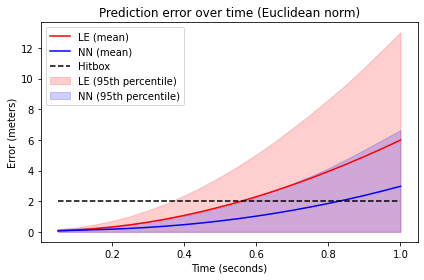

In [ ]:
mse_old = []
mse_new = []

for t in range(0, 20):
  l = []
  ln = []
  for i in range(pred.shape[0]):
    l.append(np.linalg.norm(test_Yn[i, t, :] - test_Y[i, t, :]))
    ln.append(np.linalg.norm(pred[i, t, :] - test_Y[i, t, :]))
  mse_old.append(l)
  mse_new.append(ln)

perc_old = []
perc_new = []

for i in range(0, 20):
  perc_old.append(np.percentile(mse_old[i], 95))
  perc_new.append(np.percentile(mse_new[i], 95))


plt.title("Prediction error over time (Euclidean norm)")
plt.xlabel("Time (seconds)")
plt.ylabel("Error (meters)")

ts = np.linspace(0.05, 1, 20, endpoint=True)

plt.fill_between(ts, perc_old, color="#ff000030", label="LE (95th percentile)", linestyle="solid")
plt.plot(ts, np.mean(mse_old, axis=1), color="red", linestyle="solid", label="LE (mean)")

plt.fill_between(ts, perc_new, color="#0000ff30", label="NN (95th percentile)", linestyle="solid")
plt.plot(ts,  np.mean(mse_new, axis=1), color="blue", linestyle="solid", label="NN (mean)")

plt.plot(ts, [2.0] * 20, "black", linestyle="dashed", label="Hitbox")

plt.legend(loc="upper left")

plt.tight_layout()


In [ ]:
error_y_old = []
error_xz_old = []

error_y_new = []
error_xz_new = []

for t in range(0, 20):
  l_y = []
  l_xz = []
  ln_y = []
  ln_xz = []
  for i in range(pred.shape[0]):
    ln_y.append(np.abs(test_Yn[i, t, 1] - test_Y[i, t, 1]))
    ln_xz.append(np.linalg.norm(test_Yn[i, t, [0, 2]] - test_Y[i, t, [0, 2]]))
   
    l_y.append(np.abs(pred[i, t, 1] - test_Y[i, t, 1]))
    l_xz.append(np.linalg.norm(pred[i, t, [0, 2]] - test_Y[i, t, [0, 2]]))

  error_y_old.append(ln_y)
  error_xz_old.append(ln_xz)
  error_y_new.append(l_y)
  error_xz_new.append(l_xz)
  
print(np.mean(error_y_old))
print(np.mean(error_xz_old))
print(np.mean(error_y_new))
print(np.mean(error_xz_new))

perc_y_old = []
perc_xz_old = []
perc_y_new = []
perc_xz_new = []

for i in range(0, 20):
  perc_y_old.append(np.percentile(error_y_old[i], 95))
  perc_xz_old.append(np.percentile(error_xz_old[i], 95))
  perc_y_new.append(np.percentile(error_y_new[i], 95))
  perc_xz_new.append(np.percentile(error_xz_new[i], 95))



1.1542228950176365
1.674312434947719
0.6575040776294517
0.7008522942570048


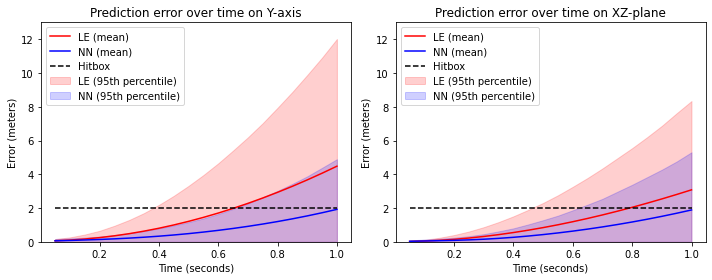

In [ ]:

ts = np.linspace(0.05, 1, 20, endpoint=True)

fig, ax = plt.subplots(ncols=2, figsize=(10,4))

ax[0].title.set_text("Prediction error over time on Y-axis")
ax[0].set_ylabel("Error (meters)")
ax[0].set_xlabel("Time (seconds)")

ax[0].set_ylim([0, 13])

ax[0].fill_between(ts, perc_xz_old, color="#ff000030", label="LE (95th percentile)", linestyle="solid")
ax[0].plot(ts, np.mean(error_xz_old, axis=1), color="red", linestyle="solid", label="LE (mean)")

ax[0].fill_between(ts, perc_xz_new, color="#0000ff30", label="NN (95th percentile)", linestyle="solid")
ax[0].plot(ts,  np.mean(error_xz_new, axis=1), color="blue", linestyle="solid", label="NN (mean)")

ax[0].plot(ts, [2.0] * 20, "black", linestyle="dashed", label="Hitbox")

ax[0].legend(loc="upper left")

ax[1].title.set_text("Prediction error over time on XZ-plane")
ax[1].set_ylabel("Error (meters)")
ax[1].set_xlabel("Time (seconds)")

ax[1].set_ylim([0, 13])

ax[1].fill_between(ts, perc_y_old, color="#ff000030", label="LE (95th percentile)", linestyle="solid")
ax[1].plot(ts, np.mean(error_y_old, axis=1), color="red", linestyle="solid", label="LE (mean)")

ax[1].fill_between(ts, perc_y_new, color="#0000ff30", label="NN (95th percentile)", linestyle="solid")
ax[1].plot(ts,  np.mean(error_y_new, axis=1), color="blue", linestyle="solid", label="NN (mean)")

ax[1].plot(ts, [2.0] * 20, "black", linestyle="dashed", label="Hitbox")

ax[1].legend(loc="upper left")

plt.tight_layout()
